In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [4]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [5]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [6]:
start = pd.Timestamp('2010-01-01')
end = pd.Timestamp('2022-04-29')

lau = web.DataReader('LAURUSLABS.NS', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

lau.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1326 entries, 2016-12-19 to 2022-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1326 non-null   float64
 1   Low        1326 non-null   float64
 2   Open       1326 non-null   float64
 3   Close      1326 non-null   float64
 4   Volume     1326 non-null   float64
 5   Adj Close  1326 non-null   float64
dtypes: float64(6)
memory usage: 72.5 KB


In [7]:
lau.head()

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2016-12-19  99.599998  95.000000  97.980003  96.080002  87741675.0  90.774628
2016-12-20  97.889999  93.139999  96.559998  94.739998  12775220.0  89.508614
2016-12-21  96.000000  94.000000  94.800003  94.680000   4620385.0  89.451942
2016-12-22  95.580002  94.000000  94.400002  94.910004   5630110.0  89.669235
2016-12-23  95.599998  94.220001  94.989998  95.129997   2094665.0  89.877090

In [8]:
hurst(lau)

array([0.62282206, 0.60737538, 0.61234346, 0.6235962 , 0.03473005,
       0.62420946])

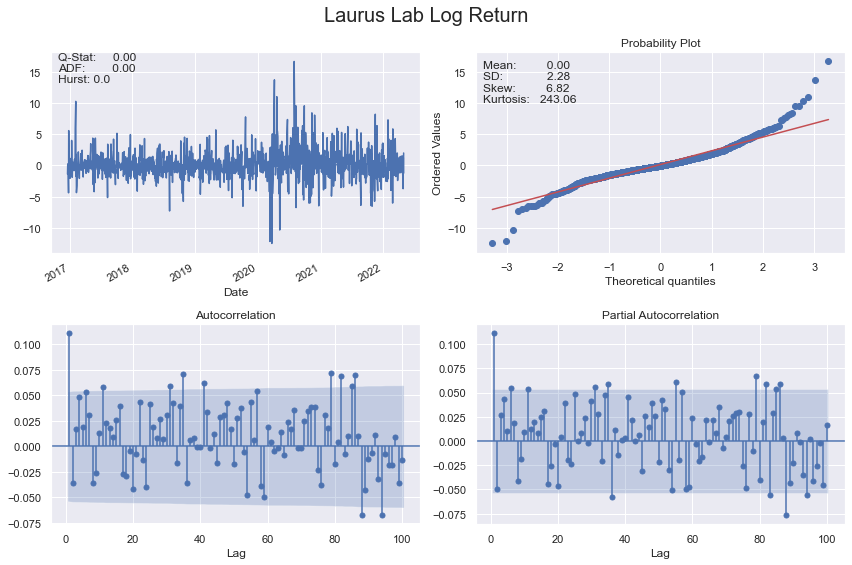

In [9]:
# Calculate daily returns as percentage price changes
lau['Return'] = 100 * (lau['Close'].pct_change())
lau['Log_Return'] = np.log(lau['Close']).diff().mul(100) # rescale to faciliate optimization
lau = lau.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(lau['Log_Return'], lags=100, title='Laurus Lab Log Return')

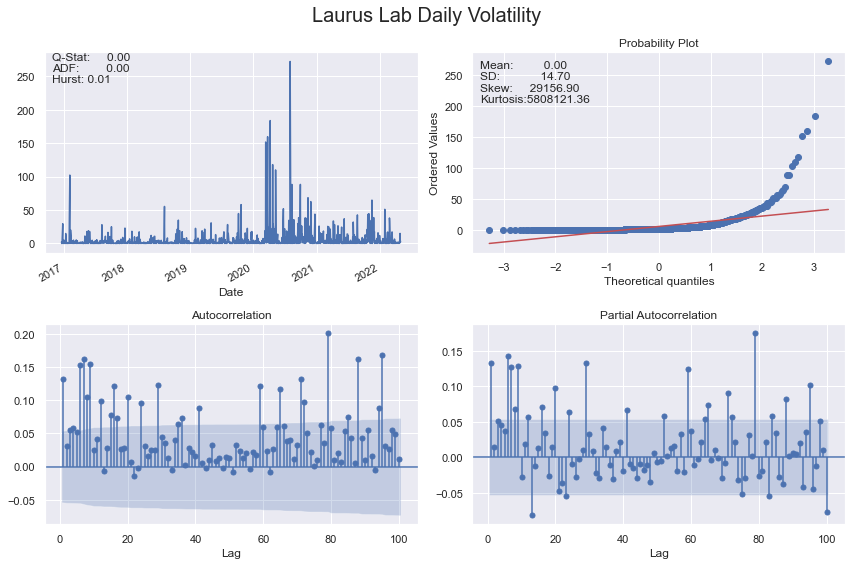

In [10]:
plot_correlogram(lau['Log_Return'].sub(lau['Log_Return'].mean()).pow(2), lags=100, title='Laurus Lab Daily Volatility')

In [11]:
# Calculate daily std of returns
std_daily = lau['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 2.3%

Monthly volatility: 10.55%

Annual volatility: 36.53%


In [12]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

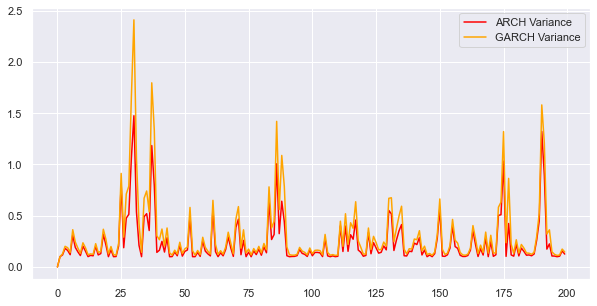

In [13]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

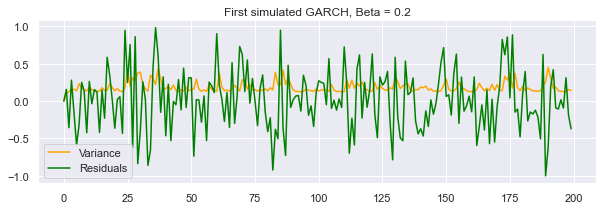

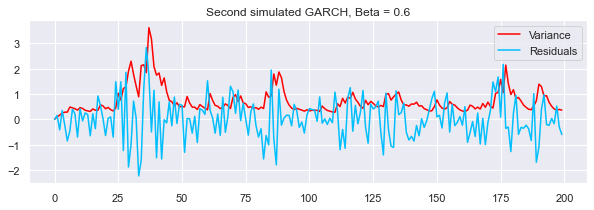

In [14]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

In [15]:
# Specify GARCH model assumptions
basic_gm = arch_model(lau['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     26,   Neg. LLF: 2873.9141266310207
Iteration:      8,   Func. Count:     51,   Neg. LLF: 2863.872933865064
Iteration:     12,   Func. Count:     70,   Neg. LLF: 2863.866988822535
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2863.866988822294
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


In [16]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2863.87
Distribution:                  Normal   AIC:                           5735.73
Method:            Maximum Likelihood   BIC:                           5756.49
                                        No. Observations:                 1325
Date:                Tue, Sep 06 2022   Df Residuals:                     1324
Time:                        21:24:33   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0653  5.674e-02      1.151      0.250 [-4.59

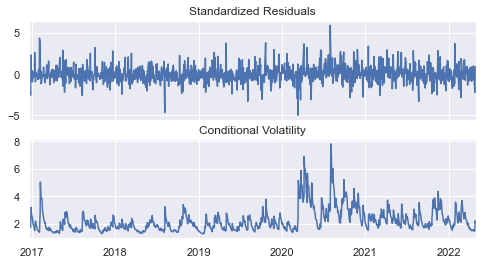

In [17]:
# Plot fitted results
gm_result.plot()
plt.show()

In [18]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1       h.2      h.3     h.4       h.5
Date                                                     
2022-04-29  4.139124  4.254702  4.36546  4.4716  4.573314


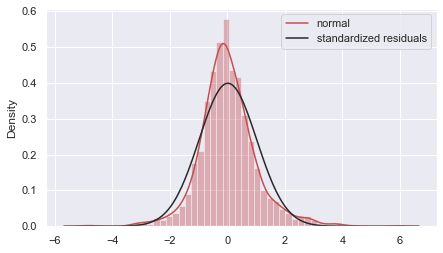

In [19]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [20]:
# Specify GARCH model assumptions
skewt_gm = arch_model(lau['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

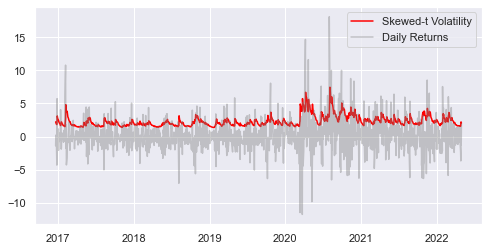

In [21]:
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(lau['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [22]:
import pmdarima as pm

model = pm.auto_arima(lau['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=5949.381, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=5955.397, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=5945.182, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=5943.604, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=5949.259, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=5956.421, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=5946.999, Time=0.09 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.601 seconds


In [23]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1325
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2964.613
Date:                Tue, 06 Sep 2022   AIC                           5933.226
Time:                        21:24:41   BIC                           5943.604
Sample:                             0   HQIC                          5937.116
                               - 1325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1247      0.020      6.262      0.000       0.086       0.164
sigma2         5.1397      0.102     50.418      0.000       4.940       5.340
Ljung-Box (L1) (Q):                   0.07   Jarque-

In [24]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=lau['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

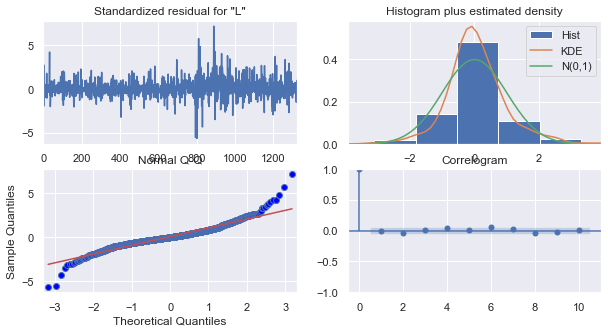

In [25]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [26]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2853.68
Distribution:                  Normal   AIC:                           5713.35
Method:            Maximum Likelihood   BIC:                           5728.92
                                        No. Observations:                 1325
Date:                Tue, Sep 06 2022   Df Residuals:                     1325
Time:                        21:24:45   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3090      0.157      1.962  4.976e-02 [3.246e-0

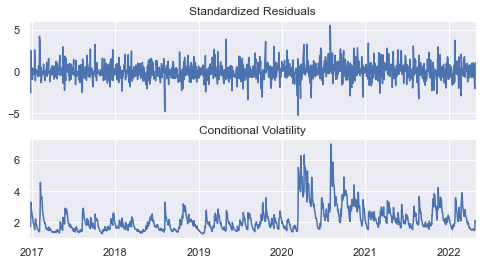

In [27]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

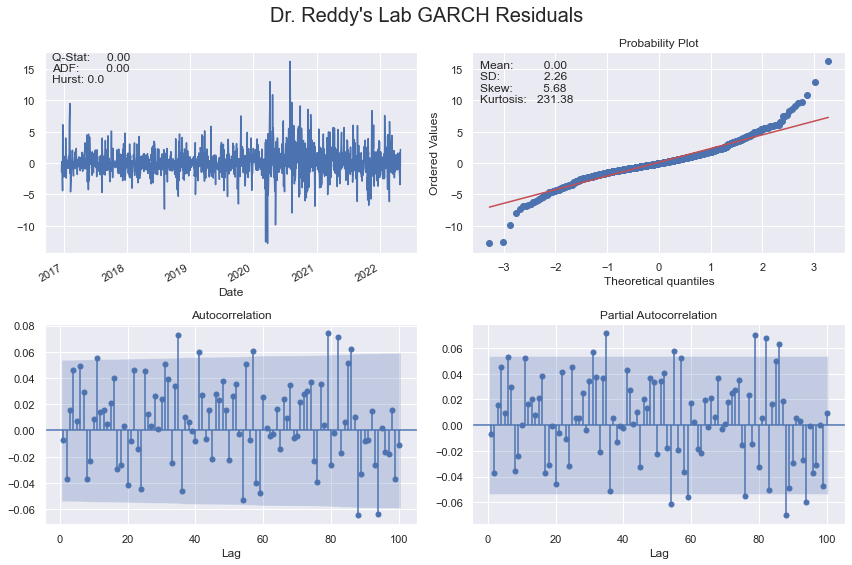

In [28]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='Dr. Reddy\'s Lab GARCH Residuals')

In [29]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(lau['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2776.65
Distribution:      Standardized Student's t   AIC:                           5565.30
Method:                  Maximum Likelihood   BIC:                           5596.44
                                              No. Observations:                 1325
Date:                      Tue, Sep 06 2022   Df Residuals:                     1324
Time:                              21:24:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [30]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(lau['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -2776.78
Distribution:      Standardized Student's t   AIC:                           5565.57
Method:                  Maximum Likelihood   BIC:                           5596.70
                                              No. Observations:                 1325
Date:                      Tue, Sep 06 2022   Df Residuals:                     1324
Time:                              21:24:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

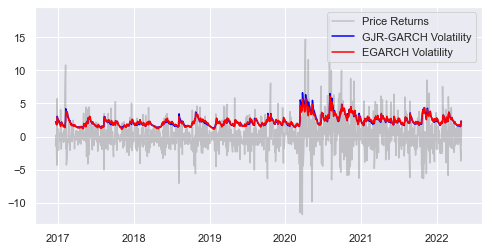

In [31]:
gjrgm_vol = gjrgm_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual Bitcoin returns
plt.plot(lau['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

In [32]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 5596.435553808958

EGARCH BIC: 5596.700573716106


In [33]:
index = lau.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


In [34]:
index = lau.index
start_loc = 0
end_loc = np.where(index >= '2022-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


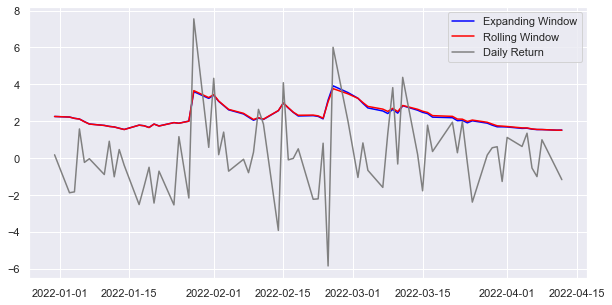

In [35]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(10,5))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(lau.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()

In [36]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter       p-value
mu         0.065288  2.498508e-01
omega      0.288168  4.322267e-02
alpha[1]   0.164439  1.119356e-02
beta[1]    0.793864  3.563389e-29


In [37]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
P-values  0.001641  0.007034  0.019132  0.020675  0.038972  0.056507   

             lag_7     lag_8     lag_9    lag_10  
P-values  0.089685  0.130961  0.173134  0.201717

In [38]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

lag_1     lag_2     lag_3     lag_4     lag_5
P-values  0.001641  0.007034  0.019132  0.020675  0.038972

In [39]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -2863.866988822294
Log-likelihood of skewt GARCH : -2773.141620255011


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(lau['Return'].sub(lau['Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 6.544
Mean Squared Error (MSE): 237.898


(6.543867830618829, 237.898076109322)